<a href="https://colab.research.google.com/github/hdavidkang/ML-Freelance-Logistics-Company/blob/main/voluntary_code_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Voluntary ML Code Work
    Author       | David Ha Eun Kang
    Beneficiary  | South Korean logistics company 🚚 🚛
    Context      | "Help us improve our business! How can we predict demand? Any rooms for logistics improvement?" 
    Data size    | 1.7 million data points (32 features) 
    Contribution | Provided an end-to-end solution from data wrangling to demand prediction 📈

### Table of contents
    1. Data Import
    
    2. Data Engineering
        2.1. Categorical features
        2.2. Regional features
            2.2.1. Standardizing notations
            2.2.2. Fixing misprints
            2.2.3. Rearranging subordinate regions
            2.2.4. Unifying zipcodes 
            2.2.5. Filtering inappropriate inputs
            2.2.6. Sifting special orders
            2.2.7. Encoding regions
        2.3. Encoding shipper codes
        2.4. Encoding item codes
        2.5. Log-scaling price info
        
    3. Custom select demand prediction options
        3.1. Select Option 1: SHPR_CD_threshold
        3.2. Select Option 2: SHPR_CD
        3.3. Select Option 3: ITEM_CD_threshold
        3.4. Select Option 4: ITEM_CD
        3.5. Select Option 5: CNEE_ADDR_1
        
    4. Demand prediction based on Deep Learning
        4.1. Data preparation
        4.2. Simple architecture
        4.3. Best parameter search
        
    5. Bonus: Diagnosis & Remedy for Shipping delay

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

le_SHPR_CD = preprocessing.LabelEncoder()
le_SHPR_ADDR_1 = preprocessing.LabelEncoder()
le_CNEE_ADDR_1 = preprocessing.LabelEncoder()
le_ITEM_CD = preprocessing.LabelEncoder()

In [2]:
class demand_forecast(object):
    
    # 1. Data Import
    # : Type in your desired month(s) of analysis in *months below. It will merge and return the data for you.
    
    def data_import(self, *months):
        data = []
        for i, month in enumerate(months):
            data.append(pd.read_csv('/content/drive/MyDrive/Colab/LC_logistics_github/ecommerce_{}_utf8.csv'.format(month), parse_dates = ['BKG_DATE' ,'INS_DATE'], low_memory = False))
        return pd.concat(data) 
       
        
    # 2. Data Engineering
    # : Prepares your data into an useful & actionable format through 7 steps of data engineering
   
    def data_engineering(self, imported_data):
        
        data = imported_data.copy()
        
        # 2.1. Categorical features       
        data['BKG_TYP'] = data.BKG_TYP.apply(lambda x: str(x))
        categorical = ['CORP_ID', 'BKG_TYP', 'SPLIT_EXEC_YN']
        categorical_info = ['CORP_ID_KX007', 'BKG_TYP_8', 'SPLIT_EXEC_YN_Y']
        data[categorical_info] = pd.get_dummies(data[categorical], drop_first = True)
        
        sentback_percent = data.BKG_TYP_8.value_counts(normalize = True)[1]*100
        split_percent = data.SPLIT_EXEC_YN_Y.value_counts(normalize = True)[1]*100
        print('< Brief summary of LC data >\n')
        print(f'  1. regular & split order ratio: c.a. {sentback_percent:.4f} % items in regular order, c.a. {split_percent:.4f} % items split ordered.')

        # 2.2. Regional features
            # 2.2.1. Standardizing notations
        data['CNEE_ADDR_1'] = data.CNEE_ADDR_1.apply(lambda x:'경기도' if str(x).find('경기') != -1 else(
                                '서울특별시' if str(x).find('서울') != -1 else(
                                '제주특별시' if str(x).find('제주') != -1 else(
                                '부산광역시' if str(x).find('부산') != -1 else(
                                '인천광역시' if str(x).find('인천') != -1 else(
                                '광주광역시' if str(x).find('광주') != -1 else(
                                '대전광역시' if str(x).find('대전') != -1 else(
                                '울산광역시' if str(x).find('울산') != -1 else(
                                '대구광역시' if str(x).find('대구') != -1 else(
                                '세종특별시' if str(x).find('세종') != -1 else(
                                '전라북도' if str(x).find('전북') != -1 else(
                                '전라남도' if str(x).find('전남') != -1 else(   
                                '충청북도' if str(x).find('충북') != -1 else(  
                                '충청남도' if str(x).find('충남') != -1 else(
                                '경상북도' if str(x).find('경북') != -1 else(
                                '경상남도' if str(x).find('경남') != -1 else(
                                 '강원도' if str(x).find('강원') != -1 else x
                                )))))))))))))))))

        data['SHPR_ADDR_1'] = data.SHPR_ADDR_1.apply(lambda x: '경기도' if x=='경기' else(
                                            '세종특별시' if x=='세종특별자치시' else(
                                            '서울특별시' if x=='서울시' else x
                                            ))) 
        
            # 2.2.2. Fixing misprints
        data['CNEE_ADDR_1'] = data.CNEE_ADDR_1.apply(lambda x:'충청남도' if x=='청남도' else(
                                '서울특별시' if x=='울특별시' != -1 else(
                                '경상남도' if x=='경삼남도' else(
                                '세종특별시' if x=='종시' else x
                                ))))
        
            # 2.2.3. Rearranging subordinate regions
        data['CNEE_ADDR_2'] = data.CNEE_ADDR_1.apply(lambda x: '세종특별시' if x=='종시' else(
                                '강서구' if x=='강서구' else(
                                '청주시' if x=='청주시' else(
                                '마포구' if x=='마포구' else(
                                '영등포구' if x=='영등포구' else(
                                '상주시' if x=='상주시' else(
                                '중구' if x=='중구' else(
                                '평택시' if x=='평택시' else(
                                '화성시' if x=='화성시' else(
                                '태종로711번길' if x=='태종로711번길' else(
                                '영천시' if x=='영천시' else x
                                )))))))))))

        data['CNEE_ADDR_1'] = data.CNEE_ADDR_1.apply(lambda x:'서울특별시' if (x=='강서구') or (x=='마포구') or (x=='영등포구') or (x=='중구') else(
                                '충청북도' if (x=='청주시') else(
                                '경상북도' if (x=='상주시') else(
                                '경기도' if (x=='평택시') or (x=='화성시') else(
                                '경상북도' if (x=='태종로711번길') or (x=='영천시') else x
                                )))))
        
            # 2.2.4. Unifying zipcodes 
        data['CNEE_ADDR_1'] = data.CNEE_ADDR_1.apply(lambda x: '경기도' if x=='(12730)' or x=='[16817]' or x=='(14782)' else(
                                '세종특별시' if x=='(30100)' else(
                                '인천광역시' if x=='(22738)' else(
                                '경상남도' if x=='(53298)' else(
                                '경기도' if x=='(13279)' or x== '(13499)' else x
                                )))))

        data['CNEE_ADDR_2'] = data.CNEE_ADDR_1.apply(lambda x: '광주시' if x=='(12730)' else(
                                '용인시' if x=='[16817]' else(
                                '부천시' if x=='(14782)' else(
                                '서구' if x=='(22738)' else(
                                '거제시' if x=='(53298)' else(
                                '성남시' if x=='(13279)' or x=='(13499)' else x 
                                ))))))
        
            # 2.2.5. Filtering inappropriate inputs
        data.drop(index = data[data.CNEE_ADDR_1 == '곤지암'].index, inplace = True)
        data.drop(index = data[data.CNEE_ADDR_1 == '道路名稱首爾特別市中區麻將路1街22號（STUDIO'].index, inplace = True)
        
            # 2.2.6. Sifting special orders
        print('  2. Consignee address missing: {} cases are identified.'.format(len(data[data.CNEE_ADDR_1.isnull()])))
        print('     Delivery man code missing in {} cases and total order amount missing in {} cases'.format(sum((data.CNEE_ADDR_1.isnull()) & (data.DLVPREARRBRANCD.isnull())), sum((data.CNEE_ADDR_1.isnull()) & (data.INV_AMT.isnull()))))
        data.drop(index = data[data.CNEE_ADDR_1.isnull()].index, inplace = True)
        
            # 2.2.7. Encoding regions
        data['SHPR_ADDR_1'] = le_SHPR_ADDR_1.fit_transform(data.SHPR_ADDR_1)
        data['CNEE_ADDR_1'] = le_CNEE_ADDR_1.fit_transform(data.CNEE_ADDR_1)
        
        # 2.3. Encoding shipper codes
        data['SHPR_CD'] = le_SHPR_CD.fit_transform(data.SHPR_CD)
        
        # 2.4. Encoding item codes
        data['ITEM_CD'] = le_ITEM_CD.fit_transform(data.ITEM_CD)
        n_items = data.ITEM_CD.nunique()
        print('  3. Toal Shippers & Items: In total, {} # of shippers ordered, and {} items on site.'.format(data.SHPR_CD.nunique(), n_items))

        # 2.5. Log-scaling price info
        print('  4. Incomplete orders: {:.2f} % of orders missing total order amount. Have not led to sales.\n\n Now processing data...'.format(sum(data.INV_AMT.isnull() | data.ITEM_AMT.isnull()) / len(data) * 100))
        data.drop(index = data[data.INV_AMT.isnull() | data.ITEM_AMT.isnull()].index, inplace = True)
        data['ITEM_AMT'] = np.log(data.ITEM_AMT + 1)
        data['INV_AMT'] = np.log(data.INV_AMT + 1)
        
        return data.sort_values('BKG_DATE').reset_index(drop=True)
    
    
    # 3. Custom select demand prediction options 
    # :  data4AI is an abbreviation of "Data for AI". The function takes an extra effort to convert your engineered data into an ML-actionable format tailored to your demand predicton needs & types.
    # :  Main perks summarized in 3 key bullets:
    
        # (1) Demand Forecast per Shipper -> Use this code to acquire dominance in business procedures!
        
            # Background: If demand forecast per shipper is unavailable in your firm, you have no choice but to stay in a passive position only 'responding' to quantity infos received.
            # Vision : ML-based demand forecast per shipper will let you take advantage in deals and help you conduct a more autonomous and proactive business with your clients.
            # Contribution: A CNN model with tuned parameters that predicts demands per shipper code.
    
         # (2) Demand Forecast per Item -> Use this code to establish operatoinal plans for space and man-power allocation!
         
            # Background: (1) If products with frequent entry / exit from the hub are located far from the main entrance / exit, inventory management will become highly inefficient.
            #             (2) In addition, if you can't predict the demand for the major products, a chaos may occur in the hub for efficient pickup and inventory management.
            # Vision: ML-based demand forecast per item will help you establish space & manpower operation plan by prediting demand per item type (4 types: see below comments)
            # Contribution: (1) Identify: Capture major products whose cumulative demand in and out of the hub exceeds a certain limit.
            #               (2) Predict: Allows you to establish guidelines for future space and manpower management of the hub on a daily basis using deep learning.
            
        # (3) Demand Forecase per Region -> Use this code to establish regional main-line delivery transportations!
            
            # Background: If there are not enough vehicles to be used on regional arterial routes, the purpose of last mile delivery (LMD) cannot be achieved.
            # Vision: ML-based demand forecast per region will help you achieve your goal of fast and effieicnt last mile delivery.
            # Contribution: A CNN model with tuned parameters that predicts demands per region.
    
    
    def data4AI(self, data, SHPR_CD_threshold = 0, SHPR_CD = 0, ITEM_CD_threshold = 0, ITEM_CD = 0, CNEE_ADDR_1 = 0):
      
        # Demand forecast type: You can pick any from the below 5 options.

            # Option 1. SHPR_CD_threshold => Demand forecast on major shippers with cumulative order quantities above certain threshold of your interest.
            # Option 2. SHPR_CD => Demand forecast per shipper code.
            # Option 3. ITEM_CD_threshold  => Demand forecast on major items with cumulative order quantities above certain threshold of your interest.
            # Option 4. ITEM_CD => Demand forecast on a specific item of your interest.
            # Option 5. CNEE_ADDR_1 => Demand forecast per consignee region of your interest.

        # Select Option 1: SHPR_CD_threshold
        if SHPR_CD_threshold != 0:
            
            print('\nYou have selected the 1st demand prediction option. Prediction on major shipper with cumulative order quantities above your threshold in action as requested...\n')
            
            def SHPR_CD_morethan(data, SHPR_CD_threshold):
                boo = (data.groupby('SHPR_CD').sum().ITEM_QTY > SHPR_CD_threshold)
                return list(boo.index[boo].values)

            major_firms = SHPR_CD_morethan(LC_engineered_data, SHPR_CD_threshold)
            print("\nShippers with cumulative item quantities above {} are {}.\n".format(SHPR_CD_threshold, le_SHPR_CD.inverse_transform(major_firms)))
        
            major_firms_bool = data.SHPR_CD.apply(lambda x: True if x in major_firms else False)
            X = data[major_firms_bool].BKG_DATE.drop_duplicates().reset_index(drop=True)
            y = data[major_firms_bool].groupby('BKG_DATE').sum().ITEM_QTY.values
            
            fig, ax = plt.subplots(figsize= (12,4))
            ax.set_title(f'ITEM_QTY demand graph of major SHPR_CDs with cumulative ITEM_QTY above {SHPR_CD_threshold}')
            sns.lineplot(data = data[major_firms_bool].groupby(['BKG_DATE', 'SHPR_CD']).sum(), x = 'BKG_DATE', y = 'ITEM_QTY', hue = 'SHPR_CD', palette="flare")
            ax.legend(loc = 'upper right', labels =  le_SHPR_CD.inverse_transform(major_firms), title = 'SHPR_CD')
            
        # Select Option 2: SHPR_CD
        if SHPR_CD != 0:
            
            print('\nYou have selected the 2nd demand predition option. Prediction per shipper cd in action as requested....\nNote we identify 4 categories: steady sales, emerging sales, discontinued sales, and summer sales.')
            
            # Categorizing shippers per demand type
            steady_firms_inds = [0, 1, 3, 4, 6, 7, 8] # Existing items (7)
            emerging_firms_inds = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27] # Items with new demand (16)
            fadeout_firms_inds = [2, 5, 9] # Discontinued items (3)
            summer_firms_inds = [21, 24, 28] # Summer items (3)
            
            firm_select = le_SHPR_CD.transform([SHPR_CD])[0]
            
            if firm_select in steady_firms_inds:
                print('\nThe shipper of your selection supplied steady sales items, so you have ample data. Now moving onto the next step...\n')
            elif firm_select in emerging_firms_inds:
                print('\nThe shipper of your selection supplied emerging sales items, so not enough data for a reliable prediction...\n')
            elif firm_select in fadeout_firms_inds:
                print('\nThe shipper of your selection supplied discontinued sales items. No data available for prediction.\n')
            elif firm_select in summer_firms_inds:
                print('\nThe shipper of your selection supplied summer sales items. Have you secured enough space for summer item storage? If not, please do.\n')
            else:
                print('\nType error! The selected shipper does not exist in your system for time duration of interest. Please reconfirm the shipper code.')
                sys.exit()
                
            X = data[data.SHPR_CD == firm_select].BKG_DATE.drop_duplicates().reset_index(drop = True)
            y = data[data.SHPR_CD == firm_select].groupby('BKG_DATE').sum().ITEM_QTY.values
            
            fig, ax = plt.subplots(figsize= (12,4))
            ax.set_title(f'ITEM_QTY demand graph of SHPR_CD = {SHPR_CD}')
            sns.lineplot(x = X, y = y)
            ax.set_ylabel('Item Quantity', fontsize = 13)
            ax.set_xlabel('Order Date)', fontsize = 13)


        # Select Option 3: ITEM_CD_threshold
        if ITEM_CD_threshold != 0:
            
            print('\nYou have selected the 3rd demand predition option. Prediction on major items with cumulative order above the threshold in action as requested....\n')
            
            # Returns item code above the quantity threshold
            def ITEM_CD_morethan(data, ITEM_CD_threshold):
                boo = (data.groupby('ITEM_CD').sum().ITEM_QTY > ITEM_CD_threshold)
                return list(boo.index[boo].values) 

            major_ITEM_CDs = ITEM_CD_morethan(LC_engineered_data, ITEM_CD_threshold)

            if (len(major_ITEM_CDs)==0):
                print("\nError! There's no item with cumulative order quantity above {}. Type a smaller value.".format(ITEM_CD_threshold))
                sys.exit()
                
            print("\nItems with cumulative item quantities above {} are {}, and the demand pattern is:\n".format(ITEM_CD_threshold, le_ITEM_CD.inverse_transform(major_ITEM_CDs)))
            

            # Demand forecast on major items as a whole
            major_items_bool = data.ITEM_CD.apply(lambda x: True if x in major_ITEM_CDs else False)
            X = data[major_items_bool].BKG_DATE.drop_duplicates().reset_index(drop = True)
            y = data[major_items_bool].groupby('BKG_DATE').sum().ITEM_QTY.values
            
            fig, ax = plt.subplots(figsize= (12,4))
            ax.set_title(f'Demand graph of major ITEM_CDs with cumulative ITEM_QTY above {ITEM_CD_threshold}')
            sns.lineplot(data = data[major_items_bool].groupby(['BKG_DATE', 'ITEM_CD']).sum(), x = 'BKG_DATE', y = 'ITEM_QTY', hue = 'ITEM_CD', palette="flare")
            ax.legend(loc = 'upper right', labels =  le_ITEM_CD.inverse_transform(major_ITEM_CDs), title = 'ITEM_CD')
        
        # Select Option 4: ITEM_CD
        if ITEM_CD != 0:
            
            print('\nYou have selected the 4th demand predition option. Prediction per item cd in action as requested....\n')
            
            item_select = le_ITEM_CD.transform([ITEM_CD])[0]
            
            X = data[data.ITEM_CD == item_select].BKG_DATE.drop_duplicates().reset_index(drop = True)
            y = data[data.ITEM_CD == item_select].groupby('BKG_DATE').sum().ITEM_QTY.values
            
            fig, ax = plt.subplots(figsize= (12,4))
            ax.set_title(f'ITEM_QTY demand graph of ITEM_CD = {ITEM_CD}', fontsize = 14)
            sns.lineplot(x = X, y = y)
            ax.set_xlabel('Order Date', fontsize = 13)
            ax.set_ylabel('Item Quantity', fontsize = 13)
            ax.set_ylim([0, max(y)*1.5])
              
        
        # Select Option 5: CNEE_ADDR_1
        if CNEE_ADDR_1 != 0:
            
            print('\nYou have selected the 5th demand predition option. Prediction per consignee region in action as requested....\n')
            
            CNEE_ADDR_1_uniques = list(le_CNEE_ADDR_1.inverse_transform(data.CNEE_ADDR_1.unique()))
            if CNEE_ADDR_1 not in CNEE_ADDR_1_uniques:
                print(f'You have mis-typed the consignee region. Pleaes pick one from {CNEE_ADDR_1_uniques} :)\n')
            
            region_select = le_CNEE_ADDR_1.transform([CNEE_ADDR_1])[0]
            
            X = data[data.CNEE_ADDR_1 == region_select].BKG_DATE.drop_duplicates().reset_index(drop = True)
            y = data[data.CNEE_ADDR_1 == region_select].groupby('BKG_DATE').sum().ITEM_QTY.values
            
            fig, ax = plt.subplots(figsize= (12,4))
            ax.set_title(f'Demand graph of Consignee Address', fontsize = 14)
            sns.lineplot(x = X, y = y)
            ax.set_xlabel('Order date', fontsize = 13)
            ax.set_ylabel('Item quantity', fontsize = 13)
            ax.set_ylim([0, max(y)*1.5])
               
        return pd.concat([pd.Series(X)[:-1], pd.Series(y)[:-1]], axis=1)
    
    
    # 4. Demand prediction based on Deep Learning
    
        # Background: Deep learning is great for time series prediction, but only when the hyperparameters are well-tuned, which can take up a lot of time.
        # Purpose: We attempt to reduce to manual tuning time and find the best working model.
        # Contribution: We provide you 5 deep learning models with high performance as shown in below figures, each tuned via GridSearchCV.
    
    def demand_forecast(self, data):
        print('Here is a Deep Learning (Convolutional Neural Network, CNN) based demand forecast model on your data.\n')
        X = data.iloc[:,0] # BKG_DATE
        y = data.iloc[:,1] # ITEM_QTY
        
        scaler = MinMaxScaler()
        y_sc = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(len(y), )

        n_timesteps = 16
        n_features = 1

        # 4.1. Data preparation
        def create_data_for_supervised_learning(y_sc, window_size = n_timesteps):
            data_X = []
            data_label = []
            for i in range(len(y_sc) - window_size):
                data_X.append(y_sc[i:i+window_size])
                data_label.append(y_sc[i+window_size])
            return np.array(data_X), np.array(data_label)

        data_X, data_label = create_data_for_supervised_learning(y_sc)

        data_X = data_X.reshape((data_X.shape[0], data_X.shape[1], 1))
        data_label = data_label.reshape(len(data_label),1)
        
        # 4.2. Simple architecture
        def create_CNN(unit = 40, activation = 'relu', dropout_rate = 0.2, optimizer = 'Adam'):
            model = models.Sequential()
            model.add(Conv1D(filters = 64, kernel_size = 2, activation = activation, input_shape = (n_timesteps, n_features)))
            model.add(MaxPooling1D(2))
            model.add(Conv1D(filters = 64, kernel_size = 2, activation = activation))
            model.add(MaxPooling1D(2))
            model.add(Flatten())
            model.add(Dense(units = unit, activation = activation))
            model.add(Dropout(dropout_rate))
            model.add(Dense(units = unit, activation = activation))
            model.add(Dense(units = 1))
            model.compile(loss = 'mean_squared_error', optimizer = optimizer)
            return model

        model = KerasRegressor(build_fn = create_CNN, verbose = 0)

        # 4.3. Best parameter search
        def best_model_forecast(model, data_X, data_label):
            
            k = int(120*0.6)
            Xtrain = data_X[:k, :, :]
            Ytrain = data_label[:k]
            Xtest = data_X[k:,:,:]  
            Ytest = data_label[k:]
            
            param_grid = {'epochs': [100, 200, 300], 'batch_size':[64, 128], 'dropout_rate':[0.2, 0.3]}
            grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, verbose = 0)
            grid.fit(Xtrain, Ytrain)

            preds = scaler.inverse_transform(grid.best_estimator_.predict(Xtest).reshape(-1,1))
            Ytest = scaler.inverse_transform(Ytest.reshape(-1,1))

            dates = X[-len(Ytest):]
            df = pd.melt(pd.DataFrame({'dates' : dates, 'Ytest' : np.squeeze(Ytest), 'preds' : np.squeeze(preds)}), id_vars = ['dates'], value_vars = ['Ytest', 'preds'])
        
            fig, ax = plt.subplots(figsize = (12, 5))
            sns.lineplot(data = df, x = 'dates', y = 'value', hue = 'variable')
            ax.set_title('Item quantity Demand prediction via CNN\n', fontsize = 14)
            ax.set_xlabel('Dates', fontsize = 12)
            ax.set_ylabel('Item quantity', fontsize = 12)
            ax.set_ylim([min(min(preds),min(Ytest))/2.5, max(max(preds),max(Ytest))*1.6])
            ax.legend(loc = 'upper right', labels =  ['LC data', 'AI-generated graph (prediction)'], fontsize = 12)
        
        best_model_forecast(model, data_X, data_label)
        
        
    # 5. Bonus: Diagnosis & Remedy for Shipping delay
    
        # Background: There is an average of 15 data each month with a difference between the customer order date and the system input date by more than 4 days.
        #             As this eventually leads to delivery delays, diagnosis and solutions are needed to prevent customer inconvenience and damage to the brand image.
        # Purpose: You need to prevent any cause of delivery delay to ensure customer satisfaction and protect your brand image.
        # Contribution: (1) We reveal that the first cause of LC system input delay is incomplete order input by customers.
        #                   -> As a solution, we recommend simplifying the order process through the introduction of an automatic order information input system.
        #               (2) We reveal that the second cause of LC system input delay is the input delay by LC employees.
        #                   -> As a solution, we report the IDs of employees who needs to be re-educated any time soon.
        
    def what_delays_entry(self, LC_data, delta = 3):     
        if delta < 3:
            print('We analyze incidences with over 3 days of delay.\n')
        
        overdues = LC_data[(LC_data.INS_DATE - LC_data.BKG_DATE).dt.days > delta]

        incomplete_orders = overdues[overdues.INV_AMT.isnull()]
        belated_INS = overdues[~overdues.INV_AMT.isnull()]

        df1 = pd.concat([incomplete_orders.INS_ID, incomplete_orders.INS_ID.apply(lambda x: 'Purchaser').rename('whose_fault')], axis = 1)
        df2 = pd.concat([belated_INS.INS_ID, belated_INS.INS_ID.apply(lambda x: 'LC').rename('whose_fault')], axis = 1)

        fig, ax = plt.subplots(figsize = (14, 5))
        sns.histplot(data = pd.concat([df1, df2], axis = 0), x = 'INS_ID', hue = 'whose_fault', multiple = 'stack', shrink = 0.65)
        ax.set_title('Delayed System Input : Cause Analysis\n', fontsize = 14)
        ax.set_xlabel('System Input ID', fontsize = 12)
        ax.set_ylabel('Delay incident count', fontsize = 12)
 
        print("< LC system input delay diagnosis & solution > \n\n - A total of {} cases ({:.3f} %) of input delay occurred.\n".format(len(overdues),len(overdues)/len(LC_data)*100))
        print("1. Ideally, the period from the customer's order completion to the LC's system input should not exceed a maximum of one or two days.")
        print("2. Among them, the input delay by customers is {} cases (hereafter in blue), which corresponds to {:.3f} %, all of which have a blank order amount field.".format(len(incomplete_orders), len(incomplete_orders)/len(overdues)*100))
        print("3. Since this means that the order has not been completed by the customer, it is suggested to simplify the order process and secure the order entry completion rate by establishing an automatic order information input system.")
        print("4. Preventing delivery delay is key key success factor in the logistics sector.")
        print("5. The remaining {} cases of input delay by LC (hereafter orange) are due to the employee(s) with the IDs of {}, and we ask the employee(s) to be re-educated on the input task.".format(len(belated_INS), list(df2.INS_ID.unique())))

### 1. Data import 

In [3]:
LC = demand_forecast()
LC_data = LC.data_import(3,4,5,6)

### 2. Data Engineering

In [4]:
LC_engineered_data = LC.data_engineering(LC_data)

< Brief summary of LC data >

  1. regular & split order ratio: c.a. 0.0586 % items in regular order, c.a. 0.0009 % items split ordered.
  2. Consignee address missing: 35 cases are identified.
     Delivery man code missing in 27 cases and total order amount missing in 33 cases
  3. Toal Shippers & Items: In total, 29 # of shippers ordered, and 16932 items on site.
  4. Incomplete orders: 1.57 % of orders missing total order amount. Have not led to sales.

 Now processing data...


### 3. Demand forecast option select
You may select any option below. Examples for each are provided.

#### Option 1. Shipper Code Threshold

 : Demand forecast preparation on major shippers with cumulative order quantities above certain threshold (ex. 200 k) of your interest.


You have selected the 1st demand prediction option. Prediction on major shipper with cumulative order quantities above your threshold in action as requested...


Shippers with cumulative item quantities above 200000 are [90001302 90001443 90001541 90001542].



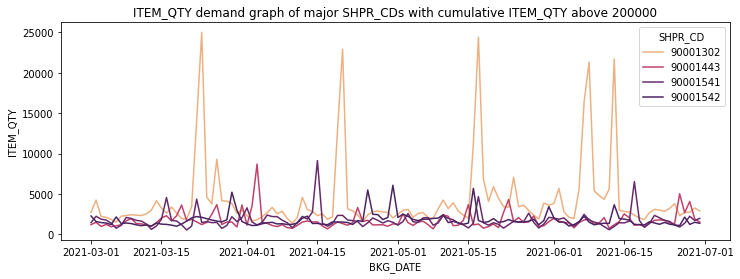

In [5]:
LC_data4AI_option1 = LC.data4AI(LC_engineered_data,
                        SHPR_CD_threshold = 200000, # option 1
                         # SHPR_CD = 90001541, # option 2
                        # ITEM_CD_threshold = 12000, # option 3
                        # ITEM_CD = '4802177320_4', # option 4
                        # CNEE_ADDR_1 = '경상북도' # option 5
                       )

#### Option 2. Shipper Code
: Demand forecast preparation per shipper code after breaking down the shipper sales type into 4 categories<br>
: (1) steady sales, (2) emerging sales, (3) discontinued sales, and (4) summer sales)


You have selected the 2nd demand predition option. Prediction per shipper cd in action as requested....
Note we identify 4 categories: steady sales, emerging sales, discontinued sales, and summer sales.

The shipper of your selection supplied steady sales items, so you have ample data. Now moving onto the next step...



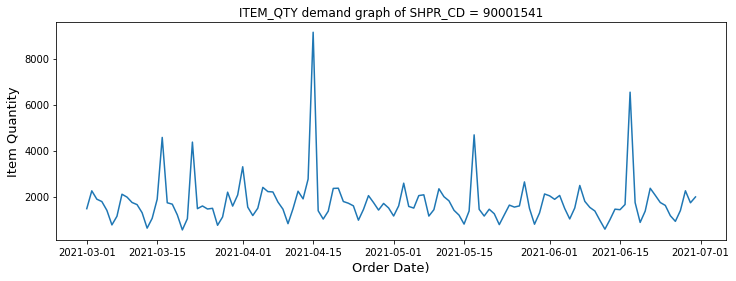

In [6]:
LC_data4AI_option2 = LC.data4AI(LC_engineered_data,
                        # SHPR_CD_threshold = 200000, # option 1
                         SHPR_CD = 90001541, # option 2
                        # ITEM_CD_threshold = 12000, # option 3
                        # ITEM_CD = '4802177320_4', # option 4
                        # CNEE_ADDR_1 = '경상북도' # option 5
                       )

#### Option 3. Item Code Threshold
: Demand forecast preparation on major items with cumulative order quantities above certain threshold (ex. 12 k) of your interest.


You have selected the 3rd demand predition option. Prediction on major items with cumulative order above the threshold in action as requested....


Items with cumulative item quantities above 12000 are ['232155349_1' '4658408144_1' '4802177320_2' '5102591063'], and the demand pattern is:



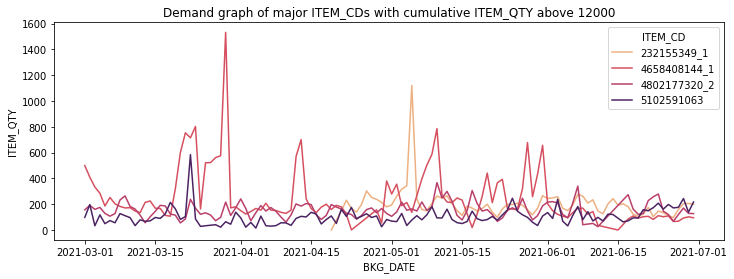

In [7]:
LC_data4AI_option3 = LC.data4AI(LC_engineered_data,
                        # SHPR_CD_threshold = 200000, # option 1
                         # SHPR_CD = 90001541, # option 2
                        ITEM_CD_threshold = 12000, # option 3
                        # ITEM_CD = '4802177320_4', # option 4
                        # CNEE_ADDR_1 = '경상북도' # option 5
                       )

#### Option 4. Item Code
: Demand forecast preparation on the selected item of your interest.


You have selected the 4th demand predition option. Prediction per item cd in action as requested....



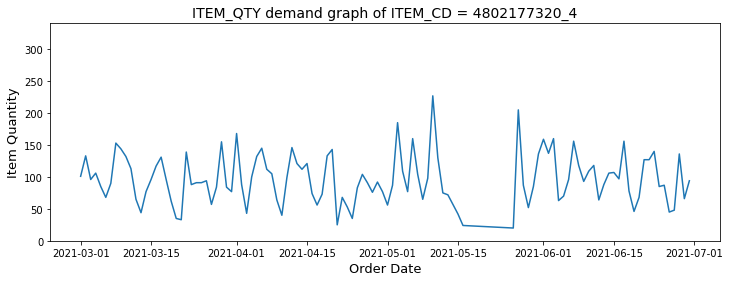

In [8]:
LC_data4AI_option4 = LC.data4AI(LC_engineered_data,
                        # SHPR_CD_threshold = 200000, # option 1
                         # SHPR_CD = 90001541, # option 2
                        # ITEM_CD_threshold = 12000, # option 3
                        ITEM_CD = '4802177320_4', # option 4
                        # CNEE_ADDR_1 = '경상북도' # option 5
                       )

#### Option 5. Consignee Address
: Demand forecast preparation per consignee address of your interest.


You have selected the 5th demand predition option. Prediction per consignee region in action as requested....



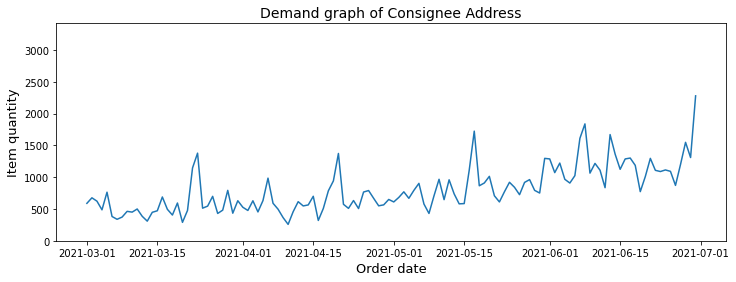

In [9]:
LC_data4AI_option5 = LC.data4AI(LC_engineered_data,
                        # SHPR_CD_threshold = 200000, # option 1
                         # SHPR_CD = 90001541, # option 2
                        # ITEM_CD_threshold = 12000, # option 3
                        # ITEM_CD = '4802177320_4', # option 4
                        CNEE_ADDR_1 = '경상북도') # option 5

### 4. Demand forecast example plots

#### Option 1. Shipper Code Threshold

Here is a Deep Learning (Convolutional Neural Network, CNN) based demand forecast model on your data.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:339: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


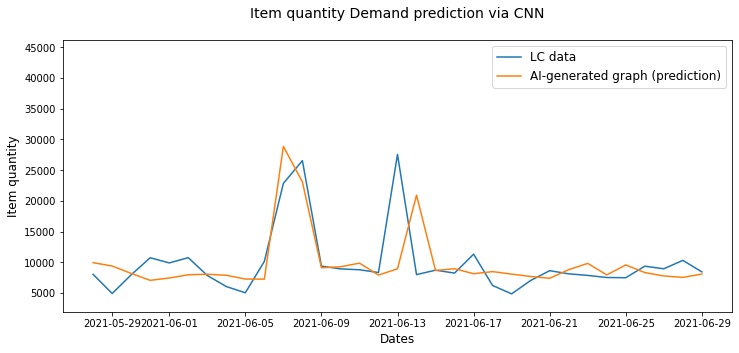

In [10]:
LC.demand_forecast(LC_data4AI_option1)

#### Option 2. Shipper Code

Here is a Deep Learning (Convolutional Neural Network, CNN) based demand forecast model on your data.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:339: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


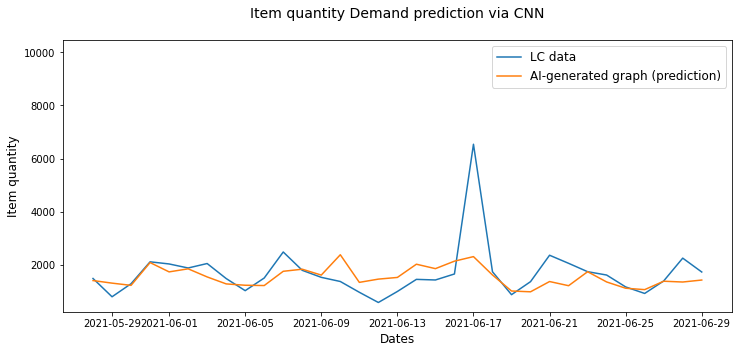

In [11]:
LC.demand_forecast(LC_data4AI_option2)

#### Option 3. Item Code Threshold

Here is a Deep Learning (Convolutional Neural Network, CNN) based demand forecast model on your data.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:339: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


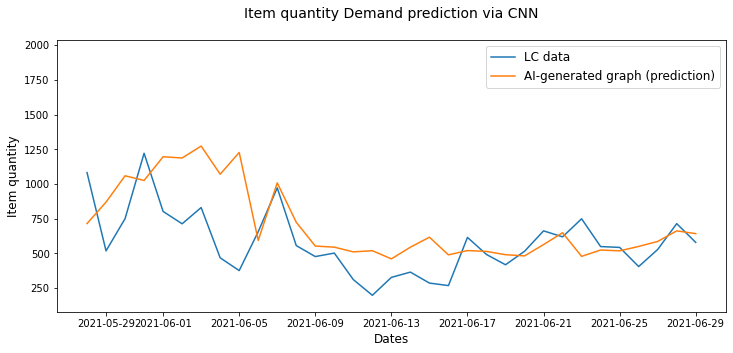

In [12]:
LC.demand_forecast(LC_data4AI_option3)

#### Option 4. Item Code

Here is a Deep Learning (Convolutional Neural Network, CNN) based demand forecast model on your data.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:339: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


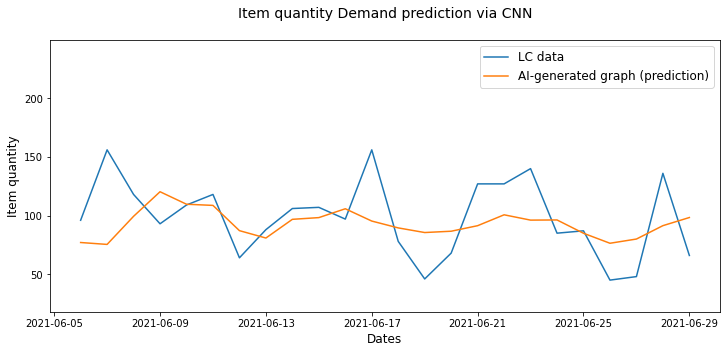

In [13]:
LC.demand_forecast(LC_data4AI_option4)

#### Option 5. Consignee Address

Here is a Deep Learning (Convolutional Neural Network, CNN) based demand forecast model on your data.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:339: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


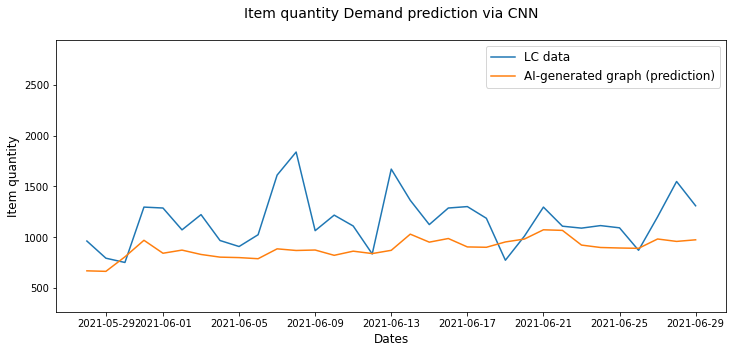

In [14]:
LC.demand_forecast(LC_data4AI_option5)

### 5. Diagnosis & Remedy for Shipping delay

< LC system input delay diagnosis & solution > 

 - A total of 885 cases (0.050 %) of input delay occurred.

1. Ideally, the period from the customer's order completion to the LC's system input should not exceed a maximum of one or two days.
2. Among them, the input delay by customers is 823 cases (hereafter in blue), which corresponds to 92.994 %, all of which have a blank order amount field.
3. Since this means that the order has not been completed by the customer, it is suggested to simplify the order process and secure the order entry completion rate by establishing an automatic order information input system.
4. Preventing delivery delay is key key success factor in the logistics sector.
5. The remaining 62 cases of input delay by LC (hereafter orange) are due to the employee(s) with the IDs of ['BATCH', 'iNEXBatch'], and we ask the employee(s) to be re-educated on the input task.


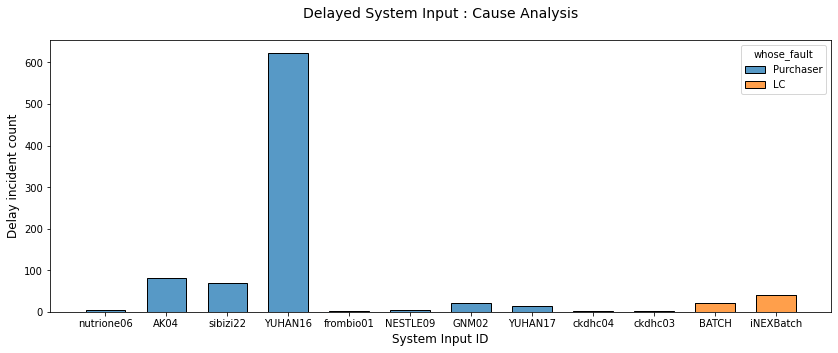

In [15]:
LC.what_delays_entry(LC_data)